This Jupyter Notebook studies the impact of the injection of various biases to the Decode function in LPR-like post-quantum primitives. The Decode function has a compression parameter d. 


This notebook investigates the minimum number of biases e such that a complete recovery of the secret output of the Decode function is possible from the impact of the biases on the Hamming Weight of the output of the Decode function. The Hamming Weight is supposedly recovered by a Side Channel Oracle.

WARNING: The minimal number of biases required for a full message recovery is computed in this notebook by creating dataframes using the pandas library from Python and then performing an exhaustive search of the solution. We do not recommend testing values of d above 7 as it can lead to memory issues. This will be addressed in a future version.

In [21]:
import pandas as pd
import itertools as iter
import matplotlib.pyplot as plt
import io
import contextlib

#Computes the Hamming Weight of an input a
def hw(a):
    return bin(a).count('1')

#Creates a table of the impact of bias +modulus*k/2^d for every integer k<2^d, with input d
def create_tab(d):
    siz = pow(2,d)
    return [[hw((j+i+1)%siz)-hw(i) for j in range(siz-1)]for i in range(siz)]

#Creates a panda dataframe of the impact of bias +modulus*k/2^d for every integer k<2^d, with input d
def create_tab_pd(d):
    dat = create_tab(d)
    return pd.DataFrame(dat)

#Creates a list of every possible combination of e elements in a list of incremental values from 0 to siz
def list_combi(siz,e):
    finlis=[]
    elem=list(range(0,siz))
    combi=iter.combinations(elem,e)
    for c in combi:
        lis=[]
        for sc in c:
            lis.append(sc)
        finlis.append(lis)    
    return finlis

#Outputs a list of all combination of e elements such as we can recover the entire output of Decode
def no_dup_list(df,e):
    finlis=[]
    com = list_combi(df.shape[1],e)
    for c in com:
        if df.iloc[:, lambda df: c].duplicated().any() == False:
            finlis.append(c)
    return finlis

#Outputs a combination of e elements such as we can recover the entire output of Decode
def no_dup_list_one(df,e):
    finlis=[]
    com = list_combi(df.shape[1],e)
    for c in com:
        if df.iloc[:, lambda df: c].duplicated().any() == False:
            finlis.append(c)
            return finlis
    return []

#Performs the attack for parameter d and e biases. Outputs an empty list if no solution is found
def attack_one(d,e):
    df = create_tab_pd(d)
    lis = no_dup_list_one(df,e)
    if not lis:
        print("There is no complete recovery for d = %d and only e = %d attempts"%(d,e))
        return []
    else:
        print("An example of complete recovery for d=%d in %d attempts is:"%(d,e))
        print(df.iloc[:,lambda df:lis[0]])
        return [d,e]
    
#Performs the attack for paramater d and e biases. Outputs an empty list if no solution is found, and the complete list 
def attack_all(d,e):
    df = create_tab_pd(d)
    lis = no_dup_list(df,e)
    if not lis:
        print("There is no complete recovery for d = %d and only e = %d attempts"%(d,e))
        return []
    else:
        print("An example of complete recovery for d = %d in e = %d attempts is:"%(d,e))
        print(df.iloc[:,lambda df:lis[0]])
        print("The full list of possible choices of e = %d ciphertexts for d = %d has length :"%(e,d))
        print(len(lis))
        #WARNING: The elements of lis are INDEXES of the columns of the dataframe. To compute the correct bias, the formula is +modulus*(index+1)/2^d
        return lis

#Exports a graph of the minimal number of biases required for every parameter d from 2 to the input maxd
def heuristic_checking(maxd,verbose=0):
    pointsX=[]
    pointsY=[]
    if not verbose:
        buffer = io.StringIO()
    e=1
    for d in range(2,maxd+1):
        lis = []
        while not lis:
            if not verbose:
                with contextlib.redirect_stdout(buffer):
                    lis = attack_one(d,e)
            else:
                lis = attack_one(d,e)
            if not lis : 
                e+=1
        pointsX.append(lis[0])
        pointsY.append(lis[1])    
    plt.plot(pointsX,pointsY,label='This work',marker='s',ls='-',c='b')
    plt.plot(pointsX,pointsX,label='Ravi et al.',marker='^',ls='-',c='r')
    plt.xlabel('Min. number of biases')
    plt.ylabel('Parameter d')
    plt.legend(loc='upper left')
    plt.savefig('heuristic_checking.png',bbox_inches='tight')

Test of the minimal number of biases required to recover the complete output of Decode for parameter d = 2 (Frodo-640)

In [22]:
d=2
lis = []
e=1
while (not lis) & (e<=d) :
    lis=attack_one(d,e)
    e+=1

There is no complete recovery for d = 2 and only e = 1 attempts
An example of complete recovery for d=2 in 2 attempts is:
   0  1
0  1  1
1  0  1
2  1 -1
3 -2 -1


Complete list of possible optimal choices of biases for d = 2 (Frodo-640). WARNING: These combinations are indexes of dataframes, add 1 to index = k in the bias formula

In [23]:
d=2
lis = []
e=1
while (not lis) & (e<=d) :
    lis=attack_all(d,e)
    e+=1
print(lis)

There is no complete recovery for d = 2 and only e = 1 attempts
An example of complete recovery for d = 2 in e = 2 attempts is:
   0  1
0  1  1
1  0  1
2  1 -1
3 -2 -1
The full list of possible choices of e = 2 ciphertexts for d = 2 has length :
3
[[0, 1], [0, 2], [1, 2]]


Test of the minimal number of biases required to recover the complete output of Decode for parameter d = 3 (Frodo-976)

In [24]:
d=3
lis = []
e=1
while (not lis) & (e<=d) :
    lis=attack_one(d,e)
    e+=1

There is no complete recovery for d = 3 and only e = 1 attempts
An example of complete recovery for d=3 in 2 attempts is:
   1  4
0  1  2
1  1  1
2  0  2
3  0 -2
4  1  0
5  1 -1
6 -2  0
7 -2 -2


Complete list of possible optimal choices of biases for d = 3 (Frodo-976). WARNING: These combinations are indexes of dataframes, add 1 to index = k in the bias formula

In [25]:
d=3
lis = []
e=1
while (not lis) & (e<=d) :
    lis=attack_all(d,e)
    e+=1
print(lis)

There is no complete recovery for d = 3 and only e = 1 attempts
An example of complete recovery for d = 3 in e = 2 attempts is:
   1  4
0  1  2
1  1  1
2  0  2
3  0 -2
4  1  0
5  1 -1
6 -2  0
7 -2 -2
The full list of possible choices of e = 2 ciphertexts for d = 3 has length :
3
[[1, 4], [2, 4], [2, 5]]


Test of the minimal number of biases required to recover the complete output of Decode for parameter d = 4 (Frodo-1344)

In [26]:
d=4
lis = []
e=1
while (not lis) & (e<=d) :
    lis=attack_one(d,e)
    e+=1

There is no complete recovery for d = 4 and only e = 1 attempts
There is no complete recovery for d = 4 and only e = 2 attempts
An example of complete recovery for d=4 in 3 attempts is:
    0  3  9
0   1  1  2
1   0  1  2
2   1  1  1
3  -1  1  1
4   1  0  2
5   0  0  2
6   1  0 -2
7  -2  0 -2
8   1  1  0
9   0  1  0
10  1  1 -1
11 -1  1 -1
12  1 -2  0
13  0 -2  0
14  1 -2 -2
15 -4 -2 -2


Complete list of possible optimal choices of biases for d = 4 (Frodo-1344). WARNING: These combinations are indexes of dataframes, add 1 to index = k in the bias formula

In [27]:
d=4
lis = []
e=1
while (not lis) & (e<=d) :
    lis=attack_all(d,e)
    e+=1
print(lis)

There is no complete recovery for d = 4 and only e = 1 attempts
There is no complete recovery for d = 4 and only e = 2 attempts
An example of complete recovery for d = 4 in e = 3 attempts is:
    0  3  9
0   1  1  2
1   0  1  2
2   1  1  1
3  -1  1  1
4   1  0  2
5   0  0  2
6   1  0 -2
7  -2  0 -2
8   1  1  0
9   0  1  0
10  1  1 -1
11 -1  1 -1
12  1 -2  0
13  0 -2  0
14  1 -2 -2
15 -4 -2 -2
The full list of possible choices of e = 3 ciphertexts for d = 4 has length :
96
[[0, 3, 9], [0, 3, 10], [0, 4, 9], [0, 4, 10], [0, 5, 9], [0, 5, 10], [0, 5, 11], [0, 5, 12], [0, 6, 10], [0, 6, 11], [0, 6, 12], [1, 4, 8], [1, 4, 10], [1, 4, 11], [1, 5, 8], [1, 5, 12], [1, 6, 12], [1, 8, 11], [1, 8, 12], [2, 3, 8], [2, 3, 9], [2, 4, 8], [2, 4, 9], [2, 4, 11], [2, 5, 8], [2, 5, 9], [2, 5, 10], [2, 5, 11], [2, 5, 12], [2, 6, 8], [2, 6, 9], [2, 6, 12], [2, 6, 13], [2, 7, 12], [2, 8, 11], [2, 8, 12], [2, 8, 13], [2, 8, 14], [2, 9, 11], [2, 9, 12], [2, 9, 13], [2, 9, 14], [3, 4, 9], [3, 4, 10], [3, 5, 8

Exhusative research of the minimal number of biases for the parameter d from 2 to 7. WARNING: avoid higher values than 7

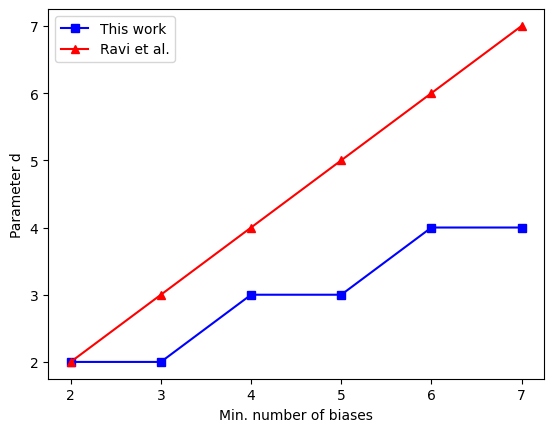

In [28]:
heuristic_checking(7)